In [4]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from tqdm import tqdm

import pickle
import os
import re

import bz2
import _pickle as cPickle

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
from keras import regularizers

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.feature_extraction.text import HashingVectorizer

In [5]:
TWEMOJI_DATASET = './datasets/samples/combined_csv.csv'
EMOJI_MAPPINGS = './datasets/emoji_map_1791.csv'
pkl_dest = os.path.join('src', 'pkl_objects')

In [6]:
twemoji = pd.read_csv(TWEMOJI_DATASET)

In [7]:
mappings = pd.read_csv(EMOJI_MAPPINGS)

In [8]:
twemoji = twemoji.reindex(np.random.permutation(twemoji.index))

# Mappings

In [9]:
# we can see that we now have the dataframe that contain all 
# the emoji mappings
mappings.head(5) 

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
0,#️⃣,symbols,keycap number sign,[hash],0023-fe0f-20e3,"[keycap, symbol, pound, hash, number]",0023_fe0f_20e3,#️⃣,NaN,NaN,NaN
1,*️⃣,symbols,keycap asterisk,[asterisk],002a-fe0f-20e3,"[keycap, symbol, asterisk, star]",002a_fe0f_20e3,*️⃣,[:keycap_asterisk:],NaN,NaN
2,0️⃣,symbols,keycap digit zero,[zero],0030-fe0f-20e3,"[, keycap, symbol, number, zero, math]",0030_fe0f_20e3,0️⃣,NaN,NaN,NaN
3,1️⃣,symbols,keycap digit one,[one],0031-fe0f-20e3,"[, keycap, symbol, number, one, math]",0031_fe0f_20e3,1️⃣,NaN,NaN,NaN
4,2️⃣,symbols,keycap digit two,[two],0032-fe0f-20e3,"[, keycap, symbol, two, number, math]",0032_fe0f_20e3,2️⃣,NaN,NaN,NaN


# Cleaning and Preparing

In [10]:
replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

In [11]:
def clean_str(x):
    x = str(x)
    
    x = x.lower()
    
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, f' {v} ')
        
    for punct in strip_chars:
        x = x.replace(punct, ' ')
        
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
    
    return x

In [12]:
# lets see how many columns 
# does the dataset have
twemoji.columns

Index(['id', 'annotations', 'id_text'], dtype='object')

In [13]:
# rename annotations to target
# rename id_text to tweet
twemoji = twemoji.rename(columns={"annotations":'target', "id_text":"text"})

In [14]:
twemoji.head() 

,id,target,text
481003,748245375362949121,1403,NaN
3606167,746219050917732354,1466,NaN
3767843,744047565268783108,1138,NaN
3356617,748444274472038400_q,1393,NaN
949968,742749517452283904,1381,NaN


In [15]:
# since the id column is no longer needed
# we can simply drop it
twemoji = twemoji.drop(columns=["id"])

In [16]:
twemoji.head()

,target,text
481003,1403,NaN
3606167,1466,NaN
3767843,1138,NaN
3356617,1393,NaN
949968,1381,NaN


In [17]:
# Lets check how many null values exist in 
# the dataset
twemoji['text'].isna().sum()

3878060

In [18]:
# We can't do much with null values
# So we drop them
twemoji = twemoji.dropna()

In [19]:
twemoji['text'] = twemoji['text'].apply(clean_str)

In [20]:
twemoji.head()

,target,text
1823397,982,white
1489455,1420,drake i love you
1511553,1446,i m about to wear sunglasses in my house becau...
1751250,1381,dead
1261454,1112,sounds like heaven to me !


In [21]:
# Lets check how big is the data set now
twemoji.shape

(88567, 2)

# Exploration

<AxesSubplot:xlabel='target'>

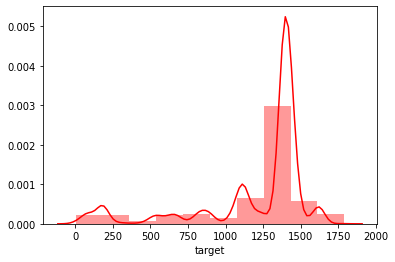

In [22]:
# lets see the distribution of our target values
sns.distplot(twemoji['target'], color='red', bins=10)

In [23]:
most_frequent = twemoji['target'].value_counts().idxmax() 
most_frequent

1381

In [24]:
# The laughing face emoji is the most popular in this dataset
mappings.loc[most_frequent]

Unnamed: 0                                                            😂
category                                                         people
title                                            face with tears of joy
shorts                                                            [joy]
unicode_alternates                                                  NaN
keywords              [emotion, cry, tear, joy, smiley, sarcastic, f...
ucode_short                                                       1f602
ucode                                                                 😂
aliases                                                             NaN
alt_title                                                           NaN
aliases_ascii                                               [:'), :'-)]
Name: 1381, dtype: object

In [25]:
# Lets see the 10 most frequently used emojis
top_twenty = twemoji['target'].value_counts()[:20].index.tolist() 
top_twenty

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [26]:
# lets see the mappings
mappings.loc[top_twenty].head()

,Unnamed: 0,category,title,shorts,unicode_alternates,keywords,ucode_short,ucode,aliases,alt_title,aliases_ascii
1381,😂,people,face with tears of joy,[joy],NaN,"[emotion, cry, tear, joy, smiley, sarcastic, f...",1f602,😂,NaN,NaN,"[:'), :'-)]"
1447,🙄,people,face with rolling eyes,"[rolling_eyes, face_with_rolling_eyes]",NaN,"[emotion, eyes, rolling eyes, smiley, sarcasti...",1f644,🙄,[:face_with_rolling_eyes:],NaN,NaN
1424,😭,people,loudly crying face,[sob],NaN,"[emotion, sob, tear, cry, smiley, sad, heartbr...",1f62d,😭,NaN,NaN,NaN
1392,😍,people,smiling face with heart shaped eyes,[heart_eyes],NaN,"[emotion, heart, eye, love, smiley, face, beau...",1f60d,😍,NaN,smiling face with heart-shaped eyes,NaN
1389,😊,people,smiling face with smiling eyes,[blush],NaN,"[emotion, beautiful, good, eye, smiley, face, ...",1f60a,😊,NaN,NaN,NaN


In [27]:
# We see that there is a high density around 1000-1500
# lets reduce the number of emojis there exists to the
# top 10 emojis that exists in the dataset
# we could reduce the complexity of our problem. 
index_names = twemoji[~twemoji['target'].isin(top_twenty)].index
twemoji = twemoji.drop(index_names)

<AxesSubplot:xlabel='target'>

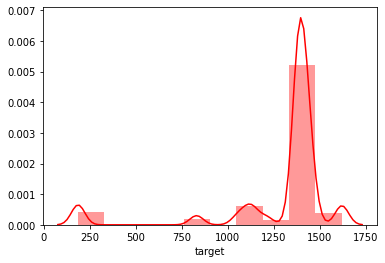

In [28]:
# lets see the distribution once again
sns.distplot(twemoji['target'], color='red', bins=10)

In [29]:
# For sanity check lets see if the remaining emojis
# are only the top ten emojis
twemoji['target'].value_counts().index.tolist() 

[1381,
 1447,
 1424,
 1392,
 1389,
 186,
 1620,
 1420,
 1446,
 1403,
 1138,
 1397,
 1384,
 1107,
 830,
 1056,
 1393,
 1380,
 1394,
 1210]

In [30]:
twemoji.shape

(44933, 2)

<AxesSubplot:xlabel='target', ylabel='count'>

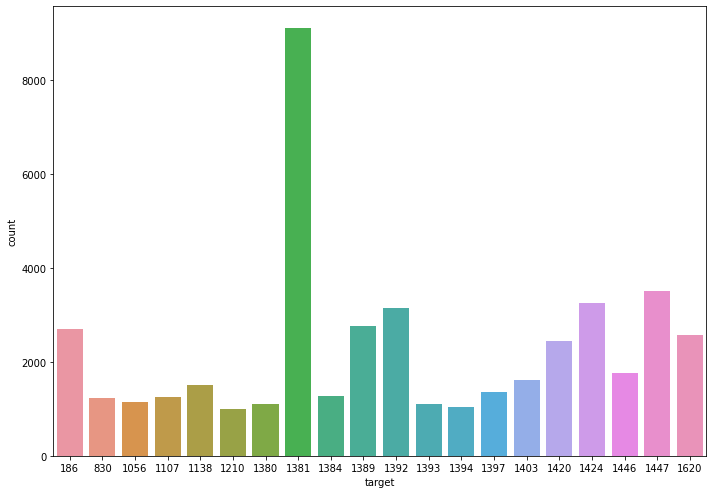

In [31]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, x='target', data=twemoji)

## Imbalance Dataset 

In [32]:
MINIMUM_CLASS_SIZE = min(np.array(twemoji['target'].value_counts()))

In [33]:
twemoji = twemoji.groupby('target').apply(lambda x: x.sample(MINIMUM_CLASS_SIZE))

In [34]:
twemoji.shape

(20080, 2)

<AxesSubplot:xlabel='target', ylabel='count'>

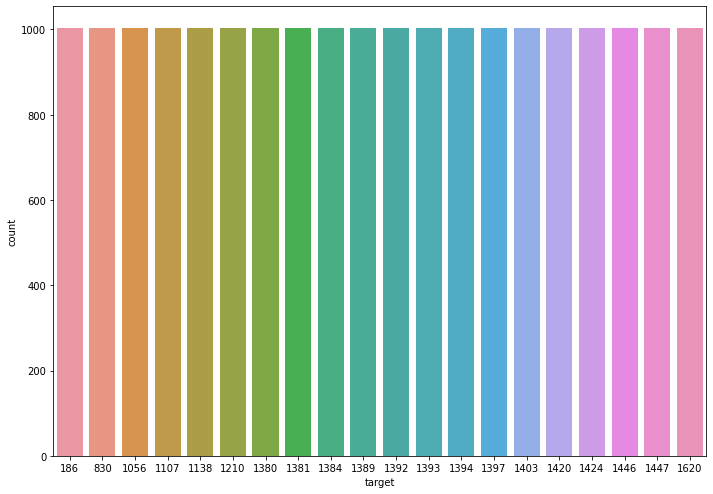

In [35]:
fig, ax = plt.subplots(figsize=(11.7, 8.27))
sns.countplot(ax=ax, x='target', data=twemoji,)

In [36]:
twemoji['l'] = twemoji['text'].apply(lambda x: len(str(x).split(' '))) 

In [37]:
print("mean length of sentence: " + str(twemoji.l.mean()))
print("max length of sentence: " + str(twemoji.l.max()))
print("std dev length of sentence: " + str(twemoji.l.std()))

mean length of sentence: 10.221065737051793
max length of sentence: 48
std dev length of sentence: 7.197116121186117


In [38]:
sequence_length = 60

## Tokenize

In [39]:
max_features = 2000 # numer of words we care about

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>', filters=' ')
tokenizer.fit_on_texts(twemoji['text'].values)

In [40]:
# convert all text to vectors
X = tokenizer.texts_to_sequences(twemoji['text'].values) 

In [41]:
# pad sequences so they are all the same length
X = pad_sequences(X, sequence_length)

In [42]:
# convert categorical var into dummy/indicator variables
y = pd.get_dummies(twemoji['target']).values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [44]:
print('Test Set Size ' + str(len(X_test)))

Test Set Size 2008


## GloVe

In [45]:
embeddings_index = {}
f = open(os.path.join('src/embeddings', 'glove.twitter.27B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close

print('Found %s word vectors' % len(embeddings_index))

Found 1193515 word vectors


In [46]:
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

Found 15398 unique tokens


In [47]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

2001


In [48]:
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

In [49]:
for word, i in word_index.items():
    if i > max_features:
        continue
        
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

## Baseline - SVM

In [93]:
def svm_tokenizer(x):
    return x.split()

In [48]:
X_train_svc, X_test_svc, y_train_svc, y_test_svc = train_test_split(twemoji['text'], twemoji['target'], test_size=0.1)

In [49]:
vect = HashingVectorizer(decode_error='ignore', n_features=max_features, preprocessor=None, tokenizer=tokenizer)

In [50]:
svc = SVC(random_state=0, verbose=True,)

In [51]:
svc.fit(vect.transform(X_train_svc), y_train_svc)

[LibSVM]

SVC(random_state=0, verbose=True)

In [56]:
y_hat = svc.predict(vect.transform(X_test_svc))

In [57]:
f1_score(list(map(lambda x: np.argmax(x), y_test_svc)), list(map(lambda x: np.argmax(x), y_hat)), average='weighted')

1.0

## Bi-LSTM

In [58]:
bi_lstm = Sequential()
bi_lstm.add(Embedding(num_words, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length, trainable=True))

bi_lstm.add(SpatialDropout1D(0.2))
bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
bi_lstm.add(Bidirectional(LSTM(32)))
bi_lstm.add(Dropout(0.25))
bi_lstm.add(Dense(units=20, activation='softmax'))
bi_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 100)           200100    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 60, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 60, 128)           84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
Total params: 327,096
Trainable params: 327,096
Non-trainable params: 0
__________________________________________________

In [60]:
batch_size = 128
history = bi_lstm.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/50
128/128 [==============================] - 8s 60ms/step - loss: 2.8755 - accuracy: 0.1080 - val_loss: 2.7414 - val_accuracy: 0.1543
Epoch 2/50
128/128 [==============================] - 7s 58ms/step - loss: 2.7471 - accuracy: 0.1476 - val_loss: 2.6845 - val_accuracy: 0.1759
Epoch 3/50
128/128 [==============================] - 8s 63ms/step - loss: 2.6837 - accuracy: 0.1628 - val_loss: 2.6589 - val_accuracy: 0.1792
Epoch 4/50
128/128 [==============================] - 8s 65ms/step - loss: 2.6322 - accuracy: 0.1805 - val_loss: 2.6241 - val_accuracy: 0.1975
Epoch 5/50
128/128 [==============================] - 8s 64ms/step - loss: 2.5918 - accuracy: 0.1930 - val_loss: 2.6162 - val_accuracy: 0.1914
Epoch 6/50
128/128 [==============================] - 9s 68ms/step - loss: 2.5566 - accuracy: 0.2035 - val_loss: 2.6106 - val_accuracy: 0.1947
Epoch 7/50
128/128 [==============================] - 9s 67ms/step - loss: 2.5192 - accuracy: 0.2172 - val_loss: 2.6042 - val_accuracy: 0.1930

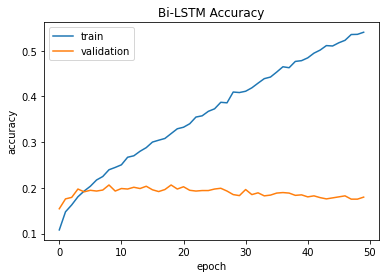

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Bi-LSTM Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

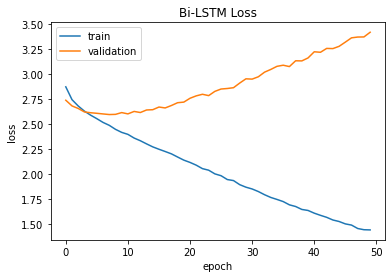

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Bi-LSTM Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [63]:
y_hat = bi_lstm.predict(X_test)

In [64]:
f1_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)), average='weighted')

0.1556853064175427

## CNN

In [88]:
cnn = Sequential()
cnn.add(Embedding(num_words, embedding_dim, 
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length, trainable=True, embeddings_regularizer=regularizers.l2(l2=1e-6)))
cnn.add(Dropout(0.6))
cnn.add(Conv1D(512, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2=1e-5)))
cnn.add(MaxPool1D(pool_size=5))
cnn.add(Flatten())
cnn.add(Dropout(0.6))
cnn.add(Dense(units=20, activation='softmax'))
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [89]:
cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 60, 100)           200100    
_________________________________________________________________
dropout_8 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 60, 512)           256512    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 12, 512)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 6144)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

In [90]:
batch_size = 128
history = cnn.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/35
128/128 [==============================] - 6s 48ms/step - loss: 3.0607 - accuracy: 0.0932 - val_loss: 2.9158 - val_accuracy: 0.1449
Epoch 2/35
128/128 [==============================] - 6s 46ms/step - loss: 2.8884 - accuracy: 0.1327 - val_loss: 2.8500 - val_accuracy: 0.1521
Epoch 3/35
128/128 [==============================] - 6s 48ms/step - loss: 2.8307 - accuracy: 0.1466 - val_loss: 2.8275 - val_accuracy: 0.1598
Epoch 4/35
128/128 [==============================] - 6s 47ms/step - loss: 2.7860 - accuracy: 0.1602 - val_loss: 2.7937 - val_accuracy: 0.1781
Epoch 5/35
128/128 [==============================] - 6s 48ms/step - loss: 2.7609 - accuracy: 0.1679 - val_loss: 2.7918 - val_accuracy: 0.1731
Epoch 6/35
128/128 [==============================] - 6s 48ms/step - loss: 2.7396 - accuracy: 0.1742 - val_loss: 2.7652 - val_accuracy: 0.1798
Epoch 7/35
128/128 [==============================] - 6s 49ms/step - loss: 2.7190 - accuracy: 0.1803 - val_loss: 2.7528 - val_accuracy: 0.1847

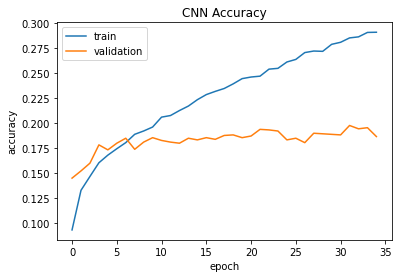

In [91]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

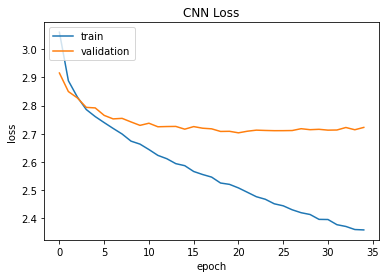

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [93]:
y_hat = cnn.predict(X_test)

In [94]:
f1_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_hat)), average='weighted')

0.18415485058264086

## Saving Models And Tokenizer

In [83]:
bi_lstm.save("src/tf_models/bi_lstm")

INFO:tensorflow:Assets written to: src/models/bi_lstm/assets


In [82]:
cnn.save("src/tf_models/cnn")

INFO:tensorflow:Assets written to: src/models/cnn/assets


In [101]:
with bz2.BZ2File('src/pkl_objects/tokenizer.pbz2', 'w') as f:
    cPickle.dump(tokenizer, f)